`page 171`

# Chapter 4

## Exercise 10

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from patsy import dmatrices
import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix

In [5]:
weekly = sm.datasets.get_rdataset('Weekly', package='ISLR').data
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


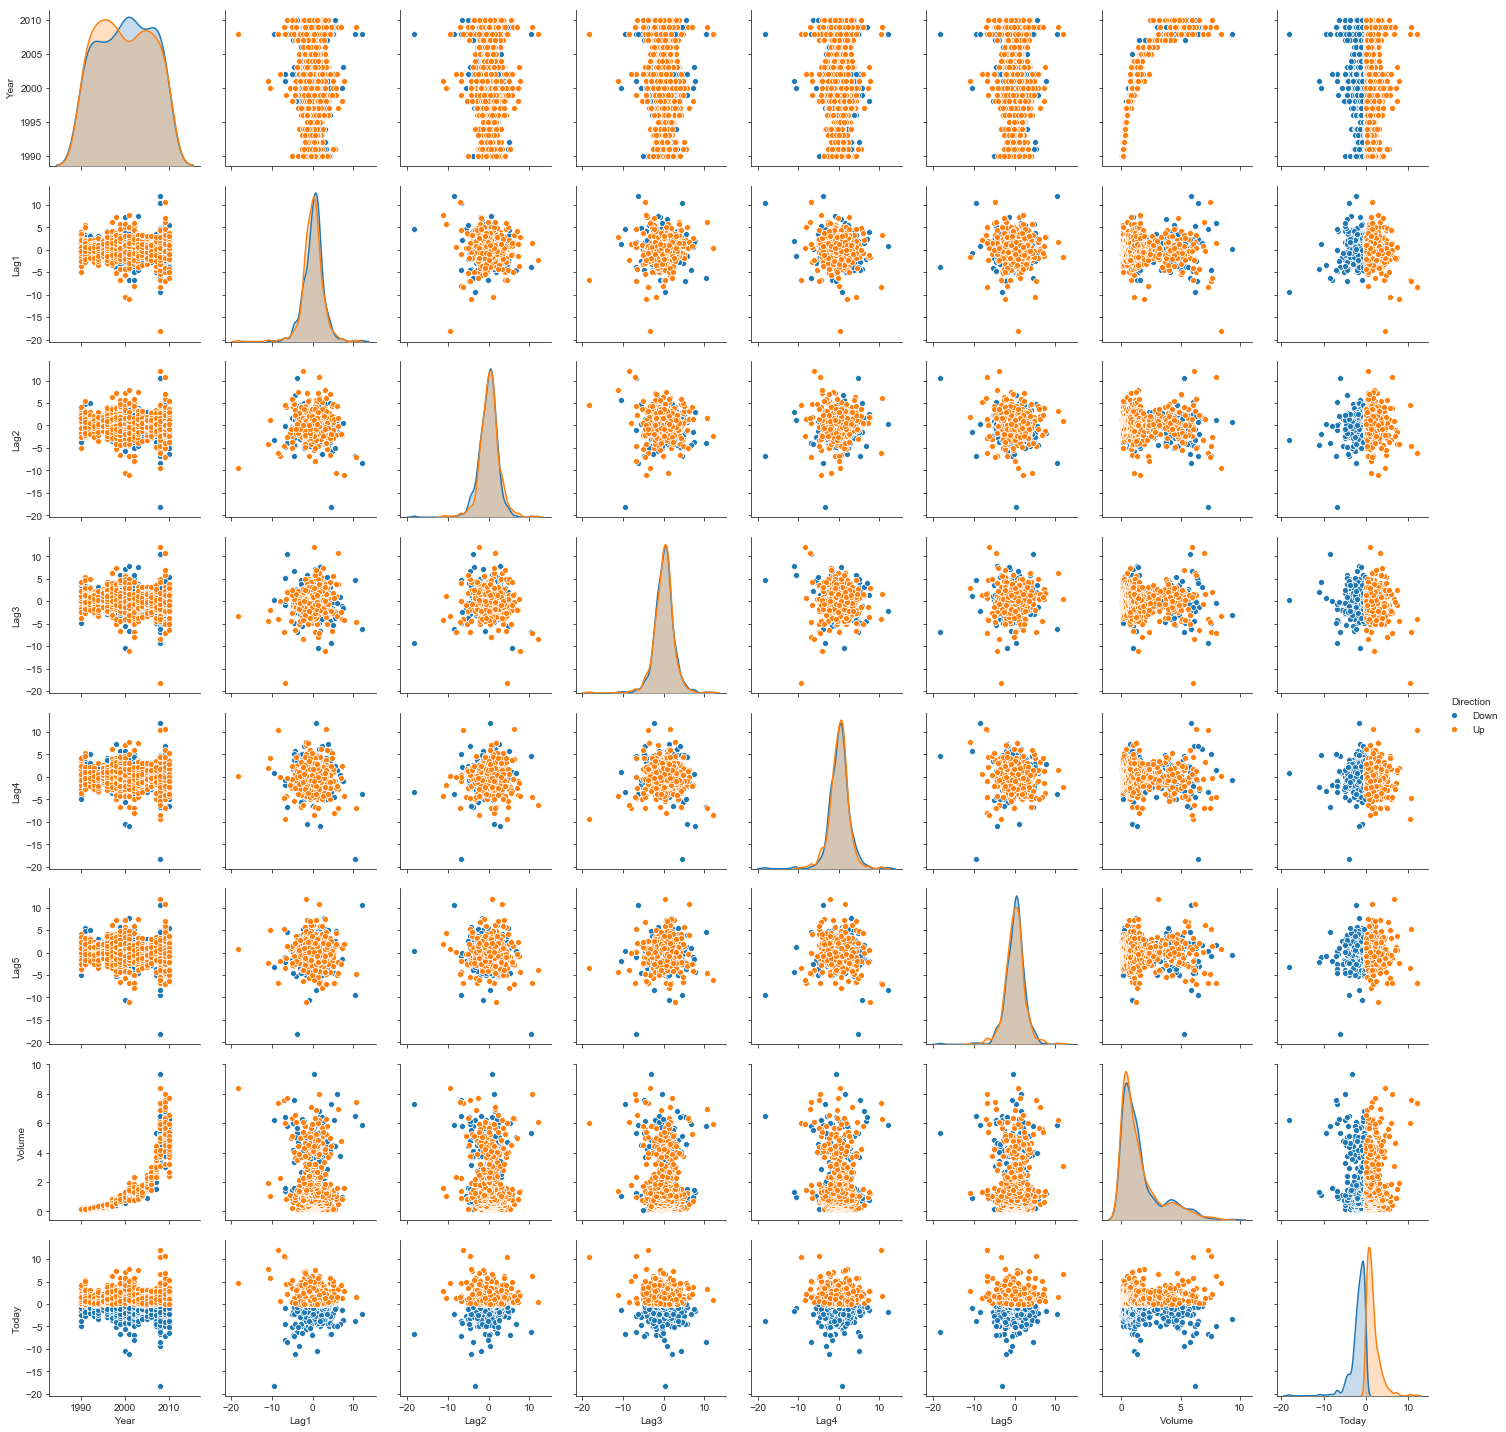

In [27]:
sns.set_style('ticks')
sns.pairplot(weekly, hue="Direction")

#### **Logistic regression**

Use `patsy` to produce design matrices, and then feed that into `endog` and `exog` variables to `sm.OLS`.

In [44]:
# Patsy's dmatrices
y, X = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', data=weekly, return_type='dataframe')

In [49]:
model = sm.Logit(y.iloc[:,1], X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sun, 10 Feb 2019   Pseudo R-squ.:                0.006580
Time:                        20:04:30   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

Only `Lag2` appear to be statistically significant with $p$-value less than $a=0.05$.

In [79]:
# Construct a dummy dataframe of model predictions
preds = pd.DataFrame(np.zeros(shape=(1089, 1)), columns=['label'])

# Change into binary value of "UP" (1) if predictions (pobability) is > 0.5
preds.iloc[model.predict() > 0.5] = 1

# Use Sklearn to print confusion matrix
confusion_matrix(y.iloc[:,1], preds.iloc[:,0]) # transpose to get in the form that is in the book, though not required
# Also model.pred_table()

array([[ 54, 430],
       [ 48, 557]], dtype=int64)

Correct predictions is given by "true" values along the diagonal, $\dfrac{54+557}{1089} = 56.1\%$.


|- |Predicted|class|
|-- |----|------|
|- | down | up |
| True down| 54 | 48   |
| True up| 430| 557  |

Logistic regression is right for weeks that market goes up: $\dfrac{557}{557+48} = 92.1\%$   
But wrong for down weeks: $\dfrac{54}{430+54} = 11.2\%$

In [86]:
# Another way to get confusion matrix
cm = pd.DataFrame({'True class': y.iloc[:,1],
                    'Predicted class': preds.iloc[:,0] > 0.5})
cm.replace(to_replace={0:'Down', 1:'Up'}, inplace=True)
cm.groupby(['Predicted class', 'True class']).size().unstack('True class')

True class,Down,Up
Predicted class,,
Down,54,48
Up,430,557


#### **Caution!** Below variables replace those defined above.

In [96]:
train_set = weekly.query('Year <= 2008')
test_set = weekly.query('Year > 2008')

# Using Patsy and Statsmodels
y_train, X_train = dmatrices('Direction~Lag2', data=train_set, return_type='dataframe')
y_test, X_test = dmatrices('Direction~Lag2', data=test_set, return_type='dataframe')

logistic_reg = sm.Logit(y_train.iloc[:,1], X_train).fit()
print(logistic_reg.summary())

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Feb 2019   Pseudo R-squ.:                0.003076
Time:                        21:48:50   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
                                        LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

In [115]:
# Get probablities
probabs = logistic_reg.predict(X_test)

# Dummy df to hold the prediction labels
preds = pd.DataFrame(np.zeros(shape=(X_test.shape[0], 1)), columns=['Prediction'])

# True/False if meets the conditional, reset index and drop=True to start index from beginning integer
label = (probabs > 0.5).reset_index(drop=True)

# Assing 1 to dummy df wherever label was True
preds[label] = 1

# Sklearn's confusion matrix
confusion_matrix(y_test.iloc[:,1], preds.iloc[:,0]).T

array([[ 9,  5],
       [34, 56]], dtype=int64)

In [116]:
# Accuracy
np.mean(y_test.iloc[:,1].reset_index(drop=True) == preds.iloc[:,0].reset_index(drop=True))

0.625

[See here](https://classeval.wordpress.com/introduction/basic-evaluation-measures/) for "Basic evaluation metrics for confusion matrix."

Accuracy rate = $\dfrac{9+56}{9+5+34+56}= 62.5\%$

#### **Linear Discriminant Analysis**

In [166]:
# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create the LDA instance
classifier = LinearDiscriminantAnalysis()

# Train the classifier
lda = classifier.fit(np.array(X_train.iloc[:,1]).reshape(-1, 1), y_train.iloc[:,1])

In [177]:
# Predictions on test 
preds = lda.predict(np.array(X_test.iloc[:,1]).reshape(-1, 1))

# Probabilities
probabs = lda.predict_proba(np.array(X_test.iloc[:,1]).reshape(-1, 1))

In [190]:
# Confusion matrix for LDA
confusion_matrix(y_test.iloc[:,1], preds).T

array([[ 9,  5],
       [34, 56]], dtype=int64)

In [186]:
# Using sklearn.LDA's score() function
lda.score(np.array(X_test.iloc[:,1]).reshape(-1, 1), y_test.iloc[:,1])

0.625

In [178]:
# Accuracy
np.mean(y_test.iloc[:,1].reset_index(drop=True) == preds)

0.625

**Conclusion:** So LDA and Logistic regression yield exactly same results (if only looking at confusion matrices and accuracy rates).

#### **Quadratic Discriminant Analysis**

In [195]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Create QDA instance
classifier = QuadraticDiscriminantAnalysis(priors=None, store_covariance=True)

# Train the classifier
qda = classifier.fit(np.array(X_train.iloc[:,1]).reshape(-1, 1), y_train.iloc[:,1])

# Predictions on test
preds = qda.predict(np.array(X_test.iloc[:,1]).reshape(-1, 1))

# Print out results
print("Accuracy:", qda.score(np.array(X_test.iloc[:,1]).reshape(-1, 1), y_test.iloc[:,1]),
     "\nConfusion matrix:\n", confusion_matrix(y_test.iloc[:,1], preds).T)

Accuracy: 0.5865384615384616 
Confusion matrix:
 [[ 0  0]
 [43 61]]


#### **K-Nearest Neighbors**

In [196]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN instance
classifier = KNeighborsClassifier(n_neighbors=1)

# Train the classifier
knn = classifier.fit(np.array(X_train.iloc[:,1]).reshape(-1, 1), y_train.iloc[:,1])

# Predictions on test
preds = knn.predict(np.array(X_test.iloc[:,1]).reshape(-1, 1))

# Print out results
print("Accuracy:", knn.score(np.array(X_test.iloc[:,1]).reshape(-1, 1), y_test.iloc[:,1]),
     "\nConfusion matrix:\n", confusion_matrix(y_test.iloc[:,1], preds).T)

Accuracy: 0.49038461538461536 
Confusion matrix:
 [[21 31]
 [22 30]]


**Conclusion:** LDA and Logistic regression provided the highest accuracy rates.
***
## Exercise 11

All vars defined below overwrite those defined above.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from patsy import dmatrices
import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix

In [2]:
auto = sm.datasets.get_rdataset('Auto', package='ISLR').data
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
median_mpg = np.median(auto['mpg'])

# Drop unnecessary cols
auto.drop(labels=['origin', 'name'], axis=1, inplace=True)

In [4]:
auto['mpg01'] = np.where(auto['mpg'] > median_mpg, 1, 0)
auto.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,mpg01
1,18.0,8,307.0,130,3504,12.0,70,0
2,15.0,8,350.0,165,3693,11.5,70,0
3,18.0,8,318.0,150,3436,11.0,70,0
4,16.0,8,304.0,150,3433,12.0,70,0
5,17.0,8,302.0,140,3449,10.5,70,0
6,15.0,8,429.0,198,4341,10.0,70,0
7,14.0,8,454.0,220,4354,9.0,70,0
8,14.0,8,440.0,215,4312,8.5,70,0
9,14.0,8,455.0,225,4425,10.0,70,0
10,15.0,8,390.0,190,3850,8.5,70,0


C:\Users\Ali Sina\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Ali Sina\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Ali Sina\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Ali Sina\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


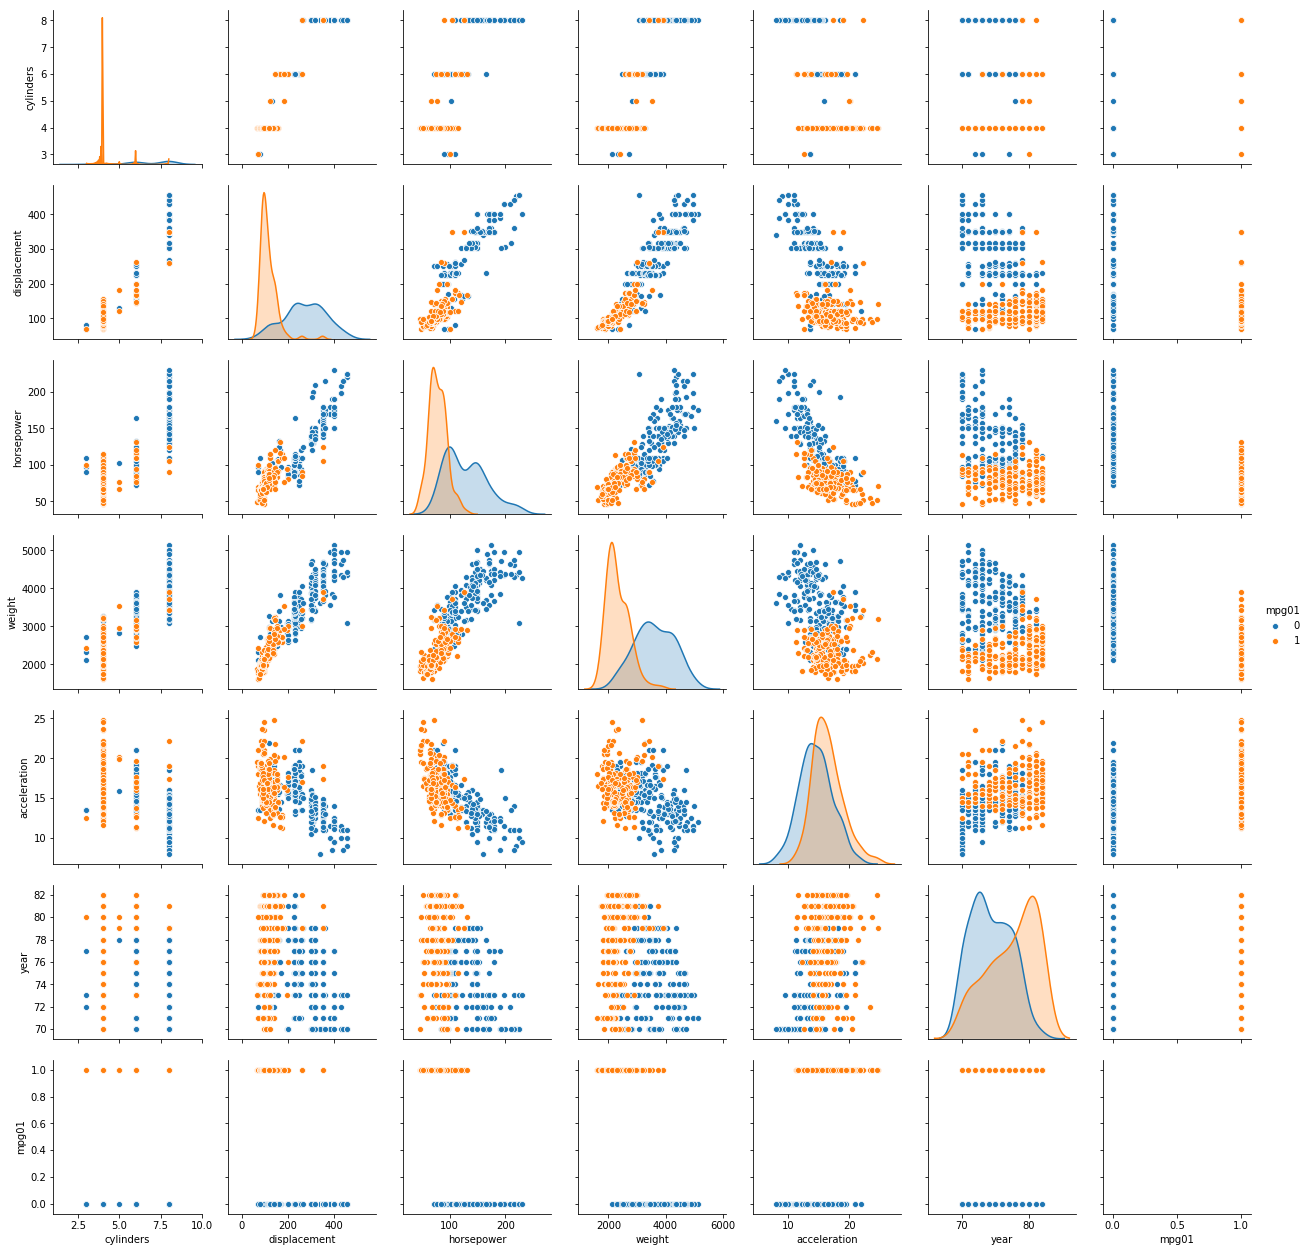

In [5]:
sns.pairplot(auto.iloc[:,1:8], hue='mpg01')
plt.show()

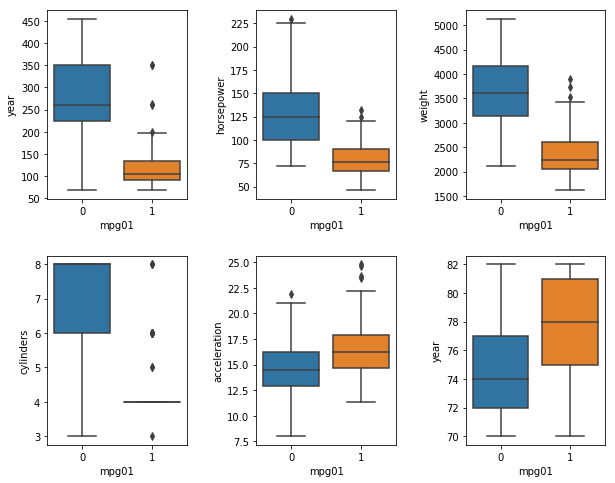

In [6]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.boxplot('mpg01', 'displacement', data=auto, orient='v', ax=ax1)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('displacement')

sns.boxplot('mpg01', 'horsepower', data=auto, orient='v', ax=ax2)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('horsepower')

sns.boxplot('mpg01', 'weight', data=auto, orient='v', ax=ax3)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('weight')

sns.boxplot('mpg01', 'cylinders', data=auto, orient='v', ax=ax4)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('cylinders')

sns.boxplot('mpg01', 'acceleration', data=auto, orient='v', ax=ax5)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('acceleration')

sns.boxplot('mpg01', 'year', data=auto, orient='v', ax=ax6)
ax1.set_xlabel('mpg01')
ax1.set_ylabel('year')

plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

In [7]:
auto.shape

(392, 8)

Remember to exclude `mpg` to avoid [data leakage](https://insidebigdata.com/2014/11/26/ask-data-scientist-data-leakage/).

In [8]:
# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(auto.iloc[:,1:7], auto['mpg01'], test_size=0.25, random_state=1)

#### **Linear Discriminant Analysis**

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create the LDA instance
classifier = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# Train the classifier
lda = classifier.fit(X_train, y_train)

# Predictions on test
preds = lda.predict(X_test)

# Print out results
print("Accuracy:", lda.score(X_test, y_test),
     "\nConfusion matrix:\n", confusion_matrix(y_test, preds).T)

Accuracy: 0.9489795918367347 
Confusion matrix:
 [[50  1]
 [ 4 43]]


In [50]:
# Alternatively, error rate
np.mean(np.array(y_test) != preds)

0.05102040816326531

#### **Quadratic Discriminant Analysis**

In [53]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Create the QDA instance
classifier = QuadraticDiscriminantAnalysis()

# Train the classifier
qda = classifier.fit(X_train, y_train)

# Predictions on test
preds = qda.predict(X_test)

# Print out results
print("Accuracy:", qda.score(X_test, y_test),
     "\nConfusion matrix:\n", confusion_matrix(y_test, preds).T)

Accuracy: 0.9489795918367347 
Confusion matrix:
 [[52  3]
 [ 2 41]]


#### **Logistic Regression**

In [56]:
from sklearn.linear_model import LogisticRegression

# Initialize LR instance
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

# Fit to training set
lrm = classifier.fit(X_train, y_train)

# Predic on test
preds = lrm.predict(X_test)

# Print out results
print("Test error rate:", np.mean(np.array(y_test) != preds),
     "\nConfusion matrix:\n", confusion_matrix(y_test, preds).T)

Test error rate: 0.030612244897959183 
Confusion matrix:
 [[53  2]
 [ 1 42]]


#### **K-Nearest Neighbors**

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN instance
classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn = classifier.fit(X_train, y_train)

# Predictions on test
preds = knn.predict(X_test)

# Print out results
print("Test error rate:", np.mean(np.array(y_test) != preds),
     "\nConfusion matrix:\n", confusion_matrix(y_test, preds).T)

Test error rate: 0.1326530612244898 
Confusion matrix:
 [[46  5]
 [ 8 39]]


I am using JupyterLab, so I cannot use the [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html) package's `interact` to interactively adjust neighbors. So here's screenshot of what I did on Jupyter Notebook to find the lowest test error.

![img](Screenshot_3.png)

In [60]:
def f(x):
    return x

interact(f, x=10);

10